In [1]:

# importar as bibliotecas necessãrias
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from googletrans import Translator
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#carrega arquivo csv em um dataframe
df_PIB = pd.read_csv('C:/Users/fidel/Dropbox/Pós Insper Data Science/MDCD/PIB_Estados_2019.csv', sep=';', encoding='latin1')

#Trocar o nome da coluna Unidades da Federação para Estado
df_PIB.rename(columns={'Unidades da Federação': 'Estado'}, inplace=True)
#Trocar o nome da colina PIB em 2021 (1.000.000 R$) para PIB   
df_PIB.rename(columns={'PIB em 2021 (1.000.000 R$)': 'PIB'}, inplace=True)
#converter a coluna PIB para float
df_PIB['PIB'] = df_PIB['PIB'].str.replace('.','')  #troca virgula por ponto
df_PIB['PIB'] = df_PIB['PIB'].astype(float) #converte para float
df_PIB.head()

,Estado,PIB
0,AC,15630.0
1,AL,58964.0
2,AP,17497.0
3,AM,108181.0
4,BA,293241.0


In [3]:
# Caminho da pasta compactada
caminho_pasta_zipada = "C:/Users/fidel/Dropbox/Pós Insper Data Science/MDCD/Dados - Olist.zip"

In [4]:
# Extrair todos os arquivos da pasta compactada para uma pasta temporária
pasta_temporaria = "pasta_temporaria"
with zipfile.ZipFile(caminho_pasta_zipada, 'r') as zip_ref:
    zip_ref.extractall(pasta_temporaria)

In [5]:
# Listar todos os arquivos na pasta temporária
arquivos_na_pasta = os.listdir(pasta_temporaria)
print(arquivos_na_pasta)
print(pasta_temporaria)

['Dados - Olist']
pasta_temporaria


In [6]:
# Diretório contendo os arquivos CSV
diretorio = 'C:/Users/fidel/Dropbox/Pós Insper Data Science/MDCD/'+pasta_temporaria+'/'+arquivos_na_pasta[0]+'/'

# Lista para armazenar os nomes dos arquivos CSV
arquivos_csv = os.listdir(diretorio)

# Dicionário para armazenar os DataFrames
dataframes = {}

# Loop sobre cada arquivo CSV
for arquivo in arquivos_csv:
    # Verifica se é um arquivo CSV
    if arquivo.endswith('.csv'):
        # Constrói o caminho completo do arquivo
        caminho_arquivo = os.path.join(diretorio, arquivo)
        # Lê o arquivo CSV e armazena no DataFrame correspondente
        nome_dataframe = os.path.splitext(arquivo)[0]  # Remove a extensão .csv
        dataframes[nome_dataframe] = pd.read_csv(caminho_arquivo)

In [7]:
base_dados = list(dataframes.keys())
base_dados

['olist_customers_dataset',
 'olist_geolocation_dataset',
 'olist_orders_dataset',
 'olist_order_items_dataset',
 'olist_order_payments_dataset',
 'olist_order_reviews_dataset',
 'olist_products_dataset',
 'olist_sellers_dataset',
 'product_category_name_translation']

In [8]:
customers = dataframes[base_dados[0]]
geolocation = dataframes[base_dados[1]]
orders = dataframes[base_dados[2]]
order_items = dataframes[base_dados[3]]
order_payments = dataframes[base_dados[4]]
order_reviews = dataframes[base_dados[5]]
products = dataframes[base_dados[6]]
sellers = dataframes[base_dados[7]]


In [9]:
# 1 Quantas linhas temos na tabela orders?
orders.shape[0]

99441

In [10]:
# 2 Quantas linhas temos na tabela orders_items?
order_items.shape[0]

112650

In [11]:
# 3 Quantas linhas temos na tabela customers?
customers.shape[0]

99441

In [12]:
# 4 Quantas linhas temos na tabela sellers?
sellers.shape[0]

3095

In [13]:
# 5 Quantas linhas temos na tabela products?
products.shape[0]

32951

In [14]:
# 6 Quantas linhas temos na tabela payments?
order_payments.shape[0]

103886

In [15]:
# 7 Quantas linhas temos na tabela orders_reviews?
order_reviews.shape[0]

99224

In [16]:
# 8 Quantas linhas temos na tabela geolocation?
geolocation.shape[0]

1000163

In [17]:
# 9 quantos CEP unicos temos na tabela geolocation?
geolocation['geolocation_zip_code_prefix'].nunique()

19015

In [18]:
# 10 Quantas latitudes e longitudes estão expressas no geolocation?
geolocation['geolocation_lat'].nunique(), geolocation['geolocation_lng'].nunique()

(717360, 717613)

In [19]:
# 11 Crie um metodo para agrupar todas as diferentes latitudes e longitudes que um determinado CEP possui para um valor unico por CEP. Dica Use a funcao group_by e aggragate
geolocation_agrupado = geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean', 'geolocation_lng':'mean'}).reset_index()
geolocation_agrupado.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [20]:
# Transformando as colunas de data (de object para data)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])

orders['prazo_estimado'] = (orders['order_estimated_delivery_date'] - orders['order_approved_at']).dt.days
orders['prazo_realizado'] = (orders['order_delivered_customer_date'] - orders['order_approved_at']).dt.days
orders['atraso'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

#Calculando o prazo médio de entrega
print(f"Prazo estimado médio: {orders.prazo_estimado.mean()}")
print(f"Prazo realizado médio: {orders.prazo_realizado.mean()}")
print(f"Atraso médio: {orders.atraso.mean()}")

Prazo estimado médio: 22.886262225400632
Prazo realizado médio: 11.642968215463084
Atraso médio: -11.876881296902857


In [21]:
# 12 mesclando os dataframes
#Mesclando os df de orders e customers
df = pd.merge(orders, customers, on='customer_id', how='left')
#Mesclando os df de orders e items
df = pd.merge(df, order_items, on='order_id', how='left')
#Mesclando os df de orders e sellers
df = pd.merge(df, sellers, on='seller_id', how='left')
#Mesclando os df de orders e payments
df = pd.merge(df, order_payments, on='order_id', how='left')
#Mesclando os df de orders e reviews
df = pd.merge(df, order_reviews, on='order_id', how='left')
#Mesclando os df de orders e products
df = pd.merge(df, products, on='product_id', how='left')
#Mesclando os df de orders e geolocation (customer = geolocation_zip_code_prefix_x)
df = pd.merge(df, geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix' , how='left')
#Mesclando os df de orders e geolocation (seller = geolocation_zip_code_prefix_y)
#df = pd.merge(df, geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix' , how='left')

In [57]:
# 13 Quantas ordens distintas temos em nosso banco de dados?
df['order_id'].nunique()

99441

In [56]:
# 14 Quantos clientes distintos existem em nosso banco de dados?
df['customer_id'].nunique()

99441

In [24]:
# 15 Quantos vendedores distintos existem em nosso bando de dados?
df['seller_id'].nunique()

3095

In [25]:
# 16 Qual a porcentagem de vendas feitas com cartao de credito?
# 17 Qual a porcentagem de vendas feitas com cartao de debito?
df['payment_type'].value_counts(normalize=True)*100


payment_type
credit_card    73.859747
boleto         19.319485
voucher         5.390940
debit_card      1.428514
not_defined     0.001314
Name: proportion, dtype: float64

In [26]:
# 16.1 Qual a porcentagem do valor das vendas feitas com cartao de credito?
# 17.1 Qual a porcentagem do valor das vendas feitas com cartao de debito?
df.groupby('payment_type')['payment_value'].sum()/df['payment_value'].sum()*100


payment_type
boleto         20.542153
credit_card    75.987126
debit_card      1.331703
not_defined     0.000000
voucher         2.139018
Name: payment_value, dtype: float64

In [27]:
#18 Qual a porcentagem de reviews com 2 estrelas temos em nossa base?
df['review_score'].value_counts(normalize=True)*100


review_score
5.0    56.647322
4.0    18.398883
1.0    13.428974
3.0     8.056633
2.0     3.468187
Name: proportion, dtype: float64

In [28]:
#19 Quantas categorias de produto distintas existem em nossa base?
df['product_category_name'].nunique()

73

In [62]:
#20 Qual a média de review por categoria de produto?
review_produtos = df.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)
review_produtos

product_category_name
cds_dvds_musicais                                4.818117
flores                                           4.765900
portateis_casa_forno_e_cafe                      4.579637
artes_e_artesanato                               4.545783
livros_tecnicos                                  4.461196
                                                   ...   
telefonia_fixa                                   3.558400
casa_conforto_2                                  3.529858
fraldas_higiene                                  2.916206
pc_gamer                                         2.876860
portateis_cozinha_e_preparadores_de_alimentos    2.860767
Name: review_score, Length: 73, dtype: float64

In [30]:
# 21 Quais as 5 categorias que mais possuem produtos em nossa base?
df['product_category_name'].value_counts().head(5)

product_category_name
cama_mesa_banho           1893596
beleza_saude              1450047
moveis_decoracao          1424181
esporte_lazer             1400020
informatica_acessorios    1265546
Name: count, dtype: int64

In [31]:
#22 Quantos comentarios existem na base?
df['review_comment_message'].count()


7485266

In [64]:
# Quantos comentários únicos existem na base?
df['review_comment_message'].nunique()

36159

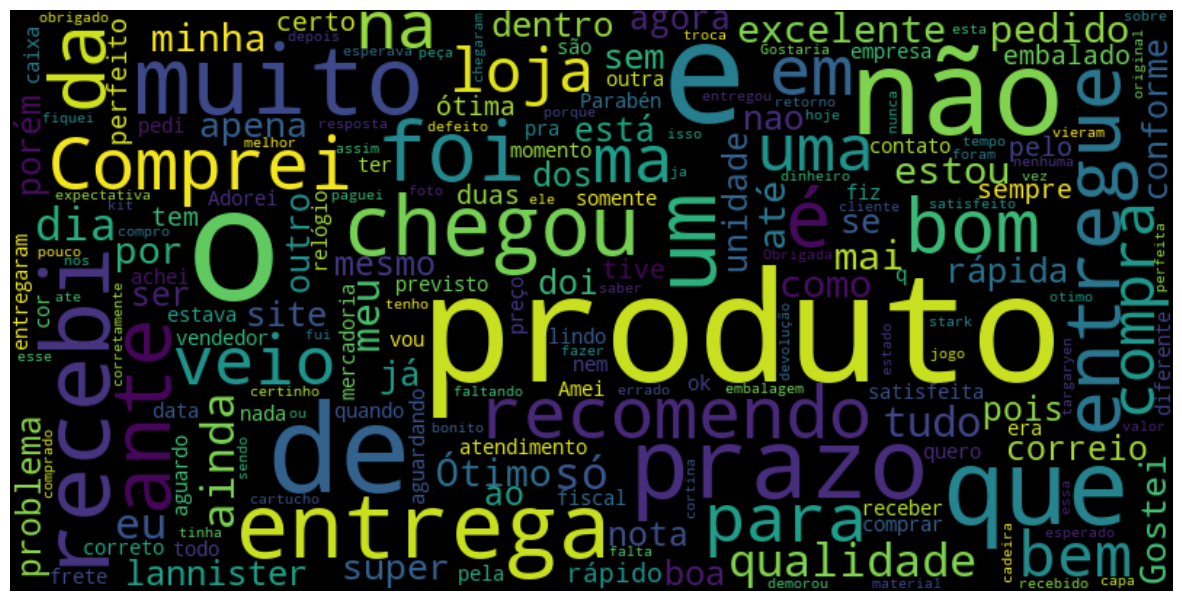

In [32]:
# 23 Crie uma nuvem de palavras que mostre as principais informacoes contidadas nos comentarios
reviews = df['review_comment_message'].dropna()
reviews = ' '.join(reviews)
wordcloud = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(reviews)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [33]:
# 24 Qual a porcentagem de ordens entregues?
df['order_status'].value_counts(normalize=True)*100

order_status
delivered      97.269426
shipped         0.910398
canceled        0.601480
unavailable     0.533170
invoiced        0.354605
processing      0.324774
approved        0.003618
created         0.002529
Name: proportion, dtype: float64

In [34]:
# 25 Qual o tempo medio entre a compra e a aprovacao da compra?

df['tempo_aprovacao'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days
df['tempo_aprovacao'].mean()

0.2700093956127818

In [35]:
# 26 Qual o tempo medio entre a compra e a entrega?
df['tempo_entrega'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['tempo_entrega'].mean()

11.776040886241619

In [36]:
# 27 Qual a diferenca media entre a data prevista de entrega e a data efetiva de entrega?
df['atraso'].mean()

-12.312102211082232

In [37]:
# 28 Em qual periodo do dia as pessoas mais costumam fazer compras por estado? Divida entre manha, tarde e noite.
df['periodo_compra'] = df['order_purchase_timestamp'].dt.hour
df['periodo_compra'] = pd.cut(df['periodo_compra'], bins=[0, 6, 12, 18, 24], labels=['madrugada', 'manha', 'tarde', 'noite'])
df.groupby('periodo_compra')['customer_state'].value_counts(normalize=True).unstack().idxmax()


customer_state
AC    madrugada
AL    madrugada
AM        tarde
AP    madrugada
BA    madrugada
CE        manha
DF        manha
ES        manha
GO        tarde
MA    madrugada
MG        manha
MS        tarde
MT        manha
PA    madrugada
PB        manha
PE    madrugada
PI    madrugada
PR        tarde
RJ    madrugada
RN        manha
RO    madrugada
RR        noite
RS        noite
SC        noite
SE        noite
SP    madrugada
TO        manha
dtype: object

In [38]:
# 29 Quais os diferentes tipos de dados temos em nossa tabela?
df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
prazo_estimado                          float64
prazo_realizado                         float64
atraso                                  float64
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           

In [47]:
# 30 Quantos clientes distintos temos por estado?
df.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False)

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_id, dtype: int64

In [46]:
# 31 Quantos vendedores distintos temos por estado?
df.groupby('customer_state')['seller_id'].nunique().sort_values(ascending=False)

customer_state
SP    2549
RJ    1751
MG    1664
RS    1232
PR    1232
SC    1038
BA     967
DF     786
ES     738
GO     724
PE     638
CE     528
MT     465
PA     465
MS     404
MA     375
PB     303
PI     297
RN     275
AL     252
SE     212
TO     199
RO     182
AM     118
AC      71
AP      63
RR      39
Name: seller_id, dtype: int64

In [66]:
# Crie uma coluna com a regiao metropolitana de São Paulo (região metrolpolitana de SP é considerada para prefixo de CEPs menores que 10000)
df['regiao_metropolitana_SP'] = np.where(df['customer_zip_code_prefix'] < 10000, 'Grande Sao Paulo', 'Outros')
# 32 Quantos clientes distintos temos na regiao metropolitana de Sao Paulo?
df[df['regiao_metropolitana_SP'] == 'Grande Sao Paulo']['customer_id'].nunique()


23995

In [67]:
# 33 Qual a media de valor, por estado, que os clientes atribuem aos vendedores?
df.groupby('customer_state')['review_score'].mean().sort_values(ascending=False)


customer_state
AP    4.258669
SP    4.117427
PR    4.099476
AC    4.096247
TO    4.064038
PB    4.062019
MG    4.043403
RN    4.043369
RS    4.027756
DF    4.008951
MS    4.007932
AM    3.992932
PE    3.982935
ES    3.971787
GO    3.964601
SC    3.944895
MT    3.935527
RO    3.931179
PI    3.889448
SE    3.854249
RJ    3.842579
CE    3.832168
PA    3.824794
BA    3.774345
AL    3.674937
MA    3.634625
RR    3.489423
Name: review_score, dtype: float64

In [44]:
# 34 Qual o valor medio de frete cobrado por estado ordenado do maior para o menor:
df.groupby('customer_state')['freight_value'].mean().sort_values(ascending=False)

customer_state
PB    43.425165
RR    42.469602
TO    41.636540
PI    39.329332
AC    39.024698
MA    37.902186
RO    37.269105
PA    36.351591
AP    35.647826
AM    34.574681
SE    34.520376
RN    33.846975
AL    33.576181
PE    32.705015
CE    32.127772
MT    29.045702
BA    26.862444
MS    24.125421
GO    23.086899
ES    21.920671
RS    21.586606
SC    21.513873
RJ    21.096975
DF    20.938538
MG    20.437859
PR    20.253940
SP    15.464187
Name: freight_value, dtype: float64

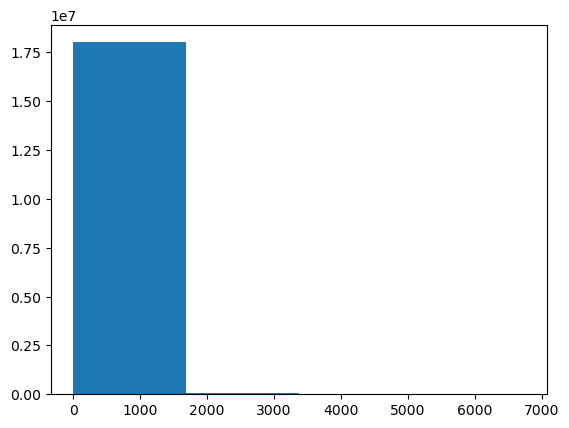

In [68]:
# 35 Faça um histograma de precos divididos em 4 quantis.
plt.hist(df['price'], bins=4)
plt.show()


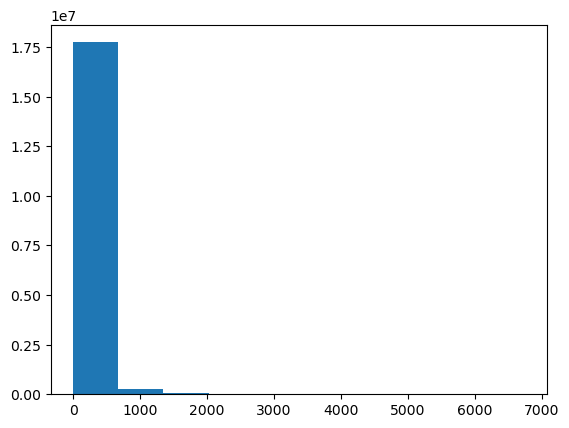

In [51]:
# 36 Trace um histograma de preços divididos em 10 quantis
plt.hist(df['price'], bins=10)
plt.show()

In [76]:
# 37 Qual a porcentagem de vendas é feita no estado de São Paulo e estão no primeiro quartil?
df['quartil'] = pd.qcut(df['payment_value'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
q1_SP = df[(df['customer_state'] == 'SP') & (df['quartil'] == 'Q1')].shape[0]/df.shape[0]*100
q1_SP

11.211686782717296

In [77]:
# 38 Qual o valor medio das compras no primeiro quartil?
media_q1_SP = df[df['quartil'] == 'Q1']['payment_value'].mean()
media_q1_SP

39.11101810688116

In [78]:
# 39 Considerando uma base de 6.000.000 de clientes na Olist, qual a quantidade de clientes no primeiro quartil e de Sao Paulo podemos atingir?
q1_SP * 6000000


67270120.69630377

In [80]:
# 40 Qual o TAM (Tamanho de Mercado) no contexto descrito anteriormente?
media_q1_SP * q1_SP * 6000000

2631002908.6052184